In [1]:
import argparse
import datetime
import json
import random
import time
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader
import datasets
from models.position_encoding import build_position_encoding_, build_position_encoding
import util.misc as utils
import datasets.samplers as samplers
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model, models_vit
from util.pos_embed import interpolate_pos_embed
from datasets.data_prefetcher import data_prefetcher
import torchvision


def get_args_parser(mode="debug", version="0"):
    parser = argparse.ArgumentParser('ViT Deformable DETR Detector', add_help=False)
    parser.add_argument('--mode', default=mode, type=str)
    parser.add_argument('--version', default=version, type=str)
    parser.add_argument('--lr', default=2e-5, type=float)
    parser.add_argument('--lr_backbone_names', default=["backbone.backbone"], type=str, nargs='+')
    parser.add_argument('--lr_backbone', default=2e-4, type=float)
    parser.add_argument('--lr_linear_proj_names', default=['reference_points', 'sampling_offsets'], type=str, nargs='+')
    parser.add_argument('--lr_linear_proj_mult', default=0.1, type=float)
    parser.add_argument('--batch_size', default=1, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=100, type=int)
    parser.add_argument('--lr_drop', default=100, type=int)
    parser.add_argument('--lr_drop_epochs', default=None, type=int, nargs='+')
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')


    parser.add_argument('--sgd', action='store_true')

    # Variants of Deformable DETR
    parser.add_argument('--with_box_refine', default=False, action='store_true')
    parser.add_argument('--two_stage', default=False, action='store_true')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")

    # * Backbone
    parser.add_argument('--poor', default=True, action='store_true',
                        help="This will freeze parameters of first 8 block of vit")
    if version == "2":
        parser.add_argument('--use_simple_fpn', default=True, action='store_true',
                            help="Determine if simple fpn is used") 
    elif version == "1" or version == "0":
        parser.add_argument('--use_simple_fpn', default=False, action='store_true',
                            help="Determine if simple fpn is used") 
    parser.add_argument('--backbone', default='vit_base_patch16', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--pretrained_backbone_path', default='', type=str,
                        help="Path to the pretrained backbone")
    # parser.add_argument('--pretrained_backbone_path', default='./pre-trained checkpoints/mae_pretrain_vit_base.pth', type=str,
    #                     help="Path to the pretrained backbone")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")
    parser.add_argument('--position_embedding_scale', default=2 * np.pi, type=float,
                        help="position / size * scale")
    parser.add_argument('--num_feature_levels', default=4, type=int, help='number of feature levels')

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=1024, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=300, type=int,
                        help="Number of query slots")
    parser.add_argument('--dec_n_points', default=4, type=int)
    parser.add_argument('--enc_n_points', default=4, type=int)

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")

    # * Matcher
    parser.add_argument('--set_cost_class', default=2, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")

    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--cls_loss_coef', default=2, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--focal_alpha', default=0.25, type=float)

    # dataset parameters
    if mode=="debug":
        parser.add_argument('--dataset_file', default='coco')
    elif mode=="train":
        parser.add_argument('--dataset_file', default='minicoco')
    parser.add_argument('--coco_path', default='detr//datasets//', type=str)
    parser.add_argument('--mini_coco_path_train_img', default='/kaggle/input/coco25k/images', type=str)
    parser.add_argument('--mini_coco_path_train_ann', default='/kaggle/input/minicoco-annotations/instances_minitrain2017.json', type=str)
    parser.add_argument('--mini_coco_path_val_img', default='/kaggle/input/coco-2017-dataset/coco2017/val2017', type=str)
    parser.add_argument('--mini_coco_path_val_ann', default='/kaggle/input/coco-2017-dataset/coco2017/annotations/instances_val2017.json', type=str)
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='../',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    if mode == "train":
        parser.add_argument('--resume', default='/kaggle/working/mDETD_'+version+'.pth', help='resume from checkpoint')
    elif mode == "debug":
        parser.add_argument('--resume', default='pre-trained checkpoints/mDETD_'+version+'.pth', help='resume from checkpoint')
        # parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=2, type=int)
    parser.add_argument('--cache_mode', default=False, action='store_true', help='whether to cache images on memory')

    return parser

In [2]:
parser = argparse.ArgumentParser('ViT Deformable DETR training and evaluation script', parents=[get_args_parser("debug", "2")])
args = parser.parse_args('')
model, _, _ = build_model(args)

In [3]:
model.to('cuda:0')

ViTDeformableDETRFull(
  (transformer): ViTDeformableTransformerFull(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, ele

In [4]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

In [5]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [6]:
len(CLASSES)

91

In [7]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [8]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [9]:
model.eval()

ViTDeformableDETRFull(
  (transformer): ViTDeformableTransformerFull(
    (encoder): DeformableTransformerEncoder(
      (layers): ModuleList(
        (0): DeformableTransformerEncoderLayer(
          (self_attn): MSDeformAttn(
            (sampling_offsets): Linear(in_features=256, out_features=256, bias=True)
            (attention_weights): Linear(in_features=256, out_features=128, bias=True)
            (value_proj): Linear(in_features=256, out_features=256, bias=True)
            (output_proj): Linear(in_features=256, out_features=256, bias=True)
          )
          (dropout1): Dropout(p=0.1, inplace=False)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout2): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
          (dropout3): Dropout(p=0.1, inplace=False)
          (norm2): LayerNorm((256,), eps=1e-05, ele

In [10]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = 'https://render.fineartamerica.com/images/rendered/default/acrylic-print/10/7/hangingwire/break/images-medium-5/boats-at-rest-ullswater-lake-beautiful-lake-district-scene-cumbria-england-uk-michael-charles.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [22]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model([img.squeeze().to('cuda:0')])

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.045

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep].to('cpu'), im.size)

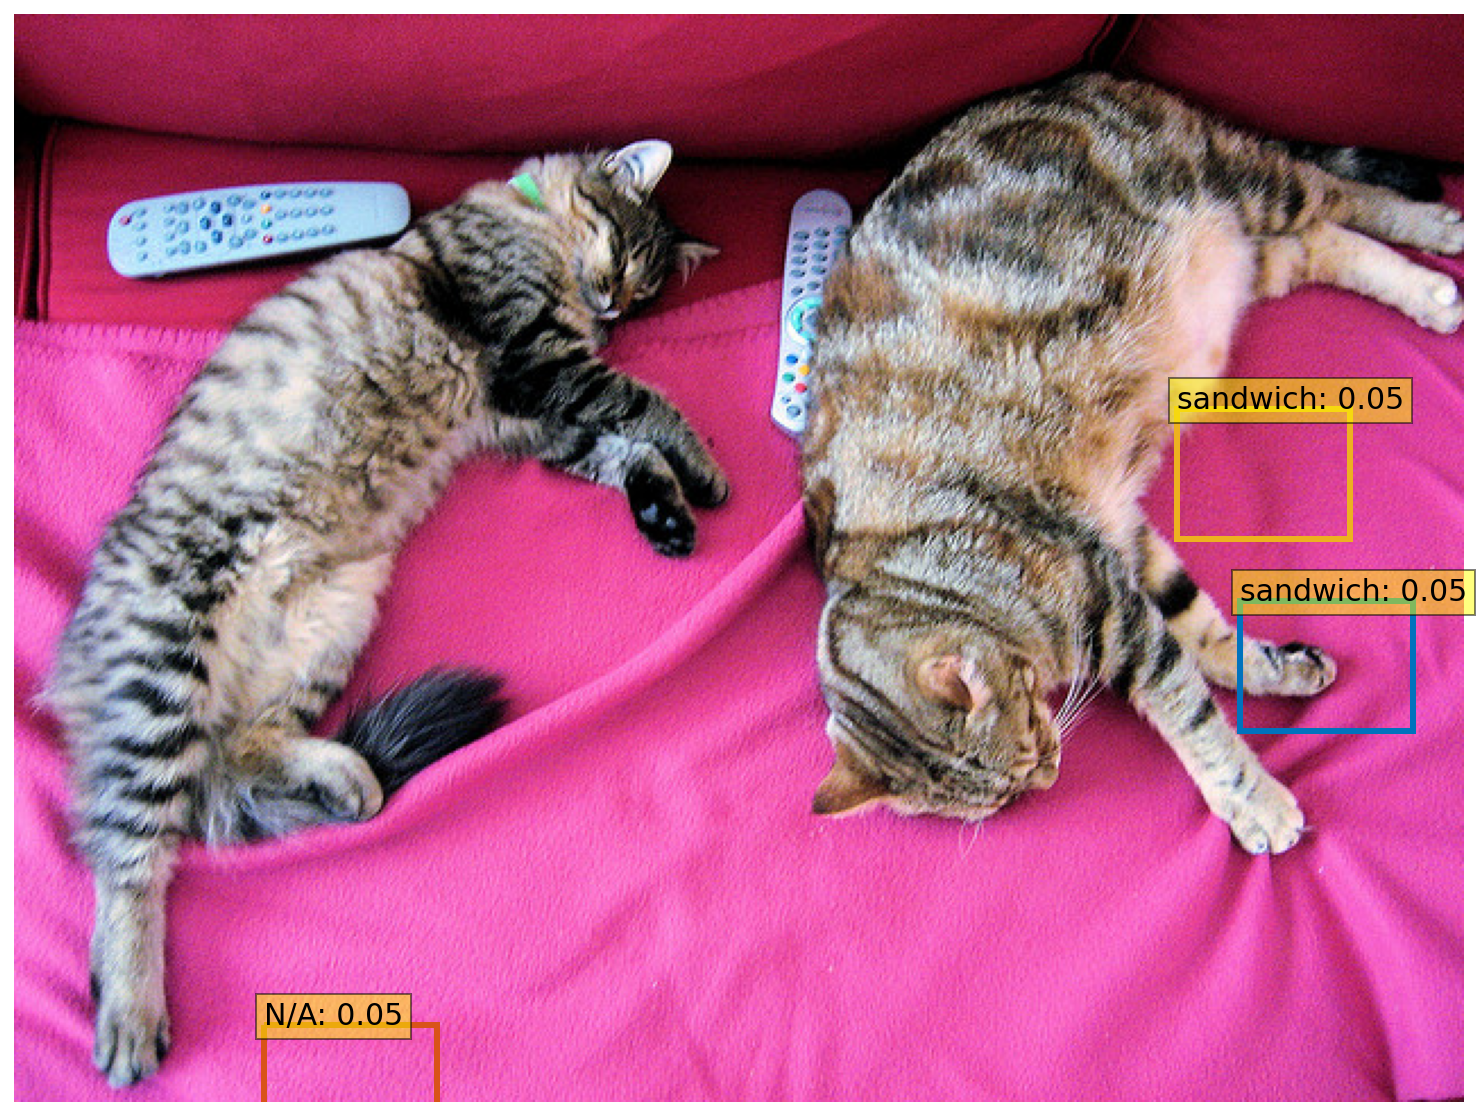

In [23]:
plot_results(im, probas[keep], bboxes_scaled)

In [24]:
# use lists to store the outputs via up-values
backbone_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone.backbone.register_forward_hook(
        lambda self, input, output: backbone_features.append(output[0])
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].cross_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# propagate through the model
outputs = model([img.squeeze().to('cuda:0')])

for hook in hooks:
    hook.remove()

# don't need the list anymore
backbone_features = backbone_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

AttributeError: 'Tensor' object has no attribute 'register_forward_hook'

In [ ]:
model.transformer.encoder.layers[-1]

In [ ]:
for backbone_feature in backbone_features:
    print(backbone_feature.shape)

In [ ]:
enc_attn_weights.shape

In [ ]:
dec_attn_weights.shape

In [ ]:
axs.T.shape

In [ ]:
keep.nonzero()

In [ ]:
# get the feature map shape
fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2*4, figsize=(22, 7))
for _, backbone_feature in enumerate(backbone_features):
    h, w = backbone_feature.shape[-2:]
    colors = COLORS * 100
    for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
        ax = ax_i[0]
        ax.imshow(dec_attn_weights[0, idx].view(h, w))
        ax.axis('off')
        ax.set_title(f'query id: {idx.item()}')
        ax = ax_i[1]
        ax.imshow(im)
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                fill=False, color='blue', linewidth=3))
        ax.axis('off')
        ax.set_title(CLASSES[probas[idx].argmax()])
    fig.tight_layout()

In [ ]:
dec_attn_weights.shape

In [ ]:
enc_attn_weights

In [ ]:
img.shape

In [ ]:
print(model)